### Data Extraction
extract essential information from JSON for the analysis
"title","views", "likes","comments", 'duration','tag','description', 'channel', 'category', 'published'

In [1]:
#extracting json to df
import os, json, re
import enum
import pandas as pd
import numpy as np
import glob
from datetime import datetime, timedelta, timezone
from itertools import groupby
import warnings

import pandas as pd
import gensim.downloader as api
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize ,word_tokenize
from nltk.corpus import stopwords
# import nltk; nltk.download('popular')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)


In [2]:

# dir = 'data'
# path = os.path.join(dir, '**/*.json')
# file_list = glob.glob(path)
# print('Total number of channels ' + str(len(file_list)))
# # print(file_list)
# dfs = list()

# for file in file_list:
#     with open(file, 'r') as f:
#         data = json.load(f)
#     channel_id, stats = data.popitem()
#     pchannel_stats = stats["channel_statistics"]
#     video_stats = stats["video_data"]
#     # sorted_vids = sorted(video_stats.items(), key=lambda item: int(item[1]["viewCount"]),reverse=True)
#     vids = video_stats.items()
#     stats = []
#     for vid in vids:
#         video_id = vid[0]
#         title = vid[1]["title"]
#         try:
#             views = vid[1]["viewCount"]
#             likes = vid[1]["likeCount"]
#             duration = vid[1]['duration']
#             tags = vid[1]['tags']
#             description = vid[1]['description']
#             comments = vid[1]["commentCount"]
#             channel = vid[1]['channelTitle']
#             published = vid[1]['publishedAt'].split('T')[0]
#         except:
#             pass
#         cat = os.path.dirname(file).split('\\')[1]
#         stats.append([title,views, published, likes, comments, duration, tags, description, channel, cat])
#     vid_df = pd.DataFrame(stats, columns=["title","views", 'published',"likes","comments", 'duration','tag','description', 'channel', 'category'])
#     dfs.append(vid_df)
# df = pd.concat(dfs, ignore_index=True)
# print('Total number of videos ' + str(df.shape[0]))


In [3]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

### Data Cleaning

In [4]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
    
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  # value = (duration_split(duration))
  for i, val in enumerate(duration_split(duration)):
    
    if len(str(duration)) <= 8:
      if i==1 and not val.isalpha():
        temp += float(val)*60
      
      if i==3 and not val.isalpha():
        temp += float(val)
    else:
      if i==1 and not val.isalpha():
        temp += float(val)*60*60
      
      if i==3 and not val.isalpha():
        temp += float(val)*60
      
      if i==5 and not val.isalpha():
        temp += float(val)

  return(temp)


# duration_2_secs("HR1PT51M12S")


In [5]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [6]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list



In [7]:
def create_dataset(df, featureset, primary=True):

  if primary:
    df["publishedAt"] = pd.to_datetime(df.publishedAt, format='%Y-%m-%d')
    # df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
    df['publishedDayDelta'] = (datetime.now(timezone.utc) - df['publishedAt']).apply(lambda x: x.days)
    df["categoryId"] = df.categoryId.astype(float)
    df["viewCount"] = df.viewCount.astype(float)
    df["likeCount"] = df.likeCount.astype(float)
    df["favoriteCount"] = df.favoriteCount.astype(float)
    df["commentCount"] = df.commentCount.astype(float)
    df['duration_secs'] = df.duration.apply(lambda x: duration_2_secs(x))
    df['topicCategories'] = df.topicCategories.apply(lambda x: topic_extract(x))
    # df['tags'] = df.tags.apply(lambda x: topic_extract(x))
    df['channelTitle'] = df.channelTitle.str.lower()
    # df['description'] = df.description.apply(lambda x: text_prep(x))
    # df['title'] = df.title.apply(lambda x: text_prep(x))
    df['log_duration_secs'] = np.log(df.duration_secs+1)
  
  else:
    df['ov_viewCount'] = df.viewCount.astype(float)
    df['ov_subscriberCount'] = df.subscriberCount.astype(float)
    df['ov_videoCount'] = df.videoCount.astype(float)
    df['channelName'] = df.channelName.str.lower()

  return df[featureset]

In [8]:
features = [
  'title', 'description', 'tags',
  'channelTitle', 'categoryId', 'viewCount', 
  'log_duration_secs', 'topicCategories', 'publishedDayDelta'
 ]

prep_df = create_dataset(raw_df, features)

In [9]:
pct_na = prep_df.isna().sum()/len(prep_df)*100
pct_na

title                0.000000
description          0.384914
tags                 6.080922
channelTitle         0.384914
categoryId           0.384914
viewCount            0.518640
log_duration_secs    0.000000
topicCategories      1.817952
publishedDayDelta    0.000000
dtype: float64

In [10]:
pct_dropna = len(prep_df.dropna())/len(prep_df)*100
pct_dropna

92.51133961002584

In [11]:
prep_df = prep_df.dropna()

### Data Mining
convert text into Word2Vec

We use gensim pretrained model called 'glove-wiki-gigaword-50' with the model trained on wikipedia dataset

In [12]:
# importing pretrained gensim model to convert text tokens into vector
model_wv = api.load('glove-wiki-gigaword-50')

In [13]:
# function to convert token to word vector with word2vec finding average vector for the document
# tokenize function with df series as input to give a list of list result of each title
def df_token(df_text_series):
    # set of english stopwords
    stopset = set(stopwords.words('english'))
    token_item = []
    for t in df_text_series:
        if type(t) == list:
            t = str(' '.join(t))
        else:
            pass
        try:
            tokens = [word for word in word_tokenize(t.lower()) if word not in stopset]
        except:
            tokens == None
        token_item.append(tokens)
    return token_item

def gen_word_vec(df_text_series, wordvec):
    word_vector = []
    for token in df_token(df_text_series):
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in wordvec.key_to_index]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(wordvec[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(wordvec.vector_size))
    word_vector = np.array(word_vector)
    return word_vector

features to work with

In [14]:
title_word_vec = gen_word_vec(prep_df.title, model_wv)
tag_word_vec = gen_word_vec(prep_df.tags, model_wv)
desc_word_vec = gen_word_vec(prep_df.description, model_wv)
topic_word_vec = gen_word_vec(prep_df.topicCategories, model_wv)

In [93]:
# with multiple features we
title_word_vec.shape

(51193, 50)

extracting cosine similarity

Reduce dimensionality using PCA

In [16]:
# initiate PCA with 1 components
pca = PCA(n_components=1)
title_pc = pca.fit_transform(title_word_vec)
tag_pc = pca.fit_transform(tag_word_vec)
desc_pc = pca.fit_transform(desc_word_vec)
topic_pc = pca.fit_transform(topic_word_vec)

In [17]:
#copy prep_df to be worked with
vec_df = prep_df.copy()
#replace df with each vector PCs
vec_df['titleVec'] = title_pc
vec_df['tags'] = tag_pc
vec_df['description'] = desc_pc
vec_df['topicCategories'] = topic_pc

In [18]:
vec_df.sample(3)

,title,description,tags,channelTitle,categoryId,viewCount,log_duration_secs,topicCategories,publishedDayDelta,titleVec
16790,4 of Physics’ (Other) Greatest Mysteries,-0.296591,-0.625202,scishow,27.0,655699.0,6.501290,1.212244,338,-0.425418
46252,"""THE TRANSFER WINDOW IS OPEN"" FIFA 17 CHELSEA ...",0.194218,-0.521673,george benson travel,20.0,51645.0,6.642487,0.128499,2088,-0.897675
21419,THE BEST LEG & BOOTY WORKOUT I'VE HAD! No Squats.,-0.035547,0.782526,krissy cela,26.0,711888.0,6.517671,-1.883525,1471,0.023520


In [19]:
vec_df.iloc[40, 0]

'Jacob Sartorius - "Hit or Miss" PARODY'

In [20]:
view_vec = vec_df.drop(columns=['channelTitle', 'title'])

In [21]:
view_vec.sample(3)

,description,tags,categoryId,viewCount,log_duration_secs,topicCategories,publishedDayDelta,titleVec
43416,-0.349561,-0.192676,27.0,197838.0,4.143135,-1.883525,4035,-0.768901
24265,0.779911,-0.878431,27.0,636501.0,5.793014,0.660740,3125,-1.168461
25566,-0.243965,-0.573629,27.0,599744.0,6.272877,0.128499,462,-0.208425


In [22]:
norm_view_vec = vec_df.copy()
norm_view_vec['averageView'] = norm_view_vec.viewCount/norm_view_vec.publishedDayDelta
norm_view_vec['normalizedView'] = norm_view_vec.groupby('channelTitle').averageView.apply(lambda x: (x-x.mean())/x.std())
norm_view_vec.drop(['channelTitle', 'viewCount', 'averageView', 'title'], axis=1, inplace=True)

In [23]:
norm_view_vec.sample(3)

,description,tags,categoryId,log_duration_secs,topicCategories,publishedDayDelta,titleVec,normalizedView
4768,-0.007204,-0.114799,23.0,5.602119,2.493353,6130,-1.260062,-0.407938
14282,-0.594033,-0.204138,24.0,6.400257,2.493353,1137,-1.101965,-0.510192
52361,0.293868,0.340314,26.0,7.902487,-1.883525,938,-0.215450,1.415265


### Unsupervised Machine Learning

In [24]:
# scale the df to be fitted with PCA
scaler = StandardScaler()
scale_view_vec = scaler.fit_transform(view_vec)
scale_norm_view_vec = scaler.fit_transform(norm_view_vec)

In [25]:
# create biplot source from https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/ + unsupervise learning class
def biplot(score, coeff, maxdim, pcax=1, pcay=2, labels=None):
    '''
    score: pca fit_transform
    coeff: components.transpose
    '''
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 1.5
    plt.figure(figsize=(12, 8))
    plt.scatter(xs*scalex, ys*scaley, s=1)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2] * text_scale_factor, "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='m', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

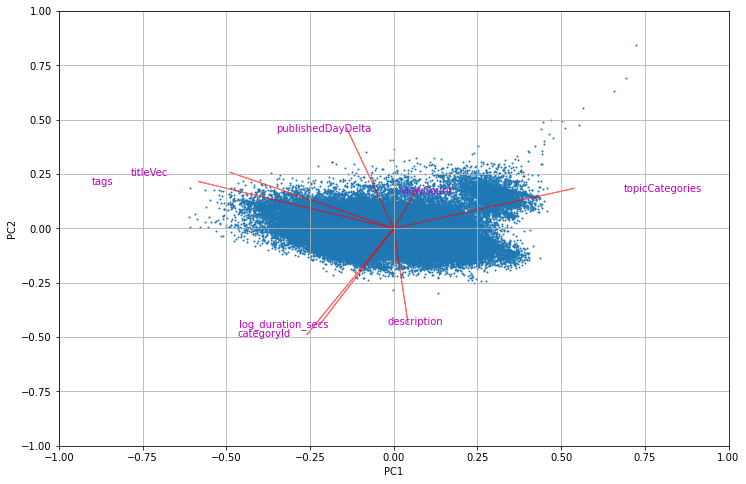

In [26]:
# biplot viewCount
score_pca = PCA(n_components=2)
score = score_pca.fit_transform(scale_view_vec)
labels = view_vec.columns
coeff = np.transpose(score_pca.components_)
biplot(score,coeff, maxdim=12, labels=labels)

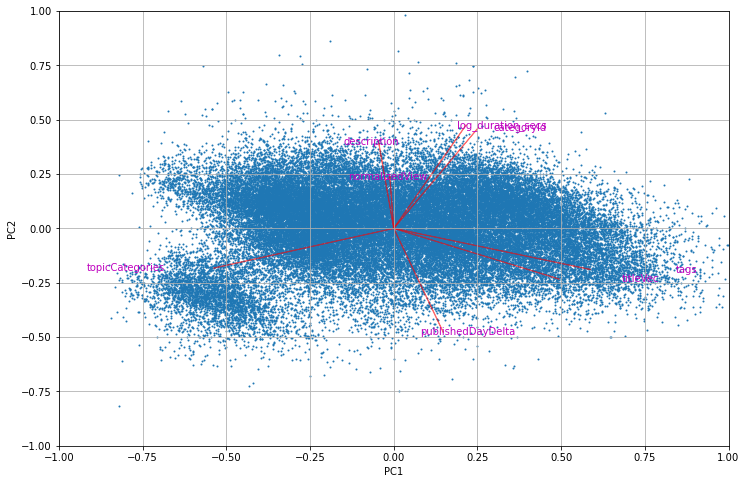

In [27]:
#biplot normalizedView
score_pca = PCA(n_components=2)
score = score_pca.fit_transform(scale_norm_view_vec)
labels = norm_view_vec.columns
coeff = np.transpose(score_pca.components_)
biplot(score,coeff, maxdim=12, labels=labels)

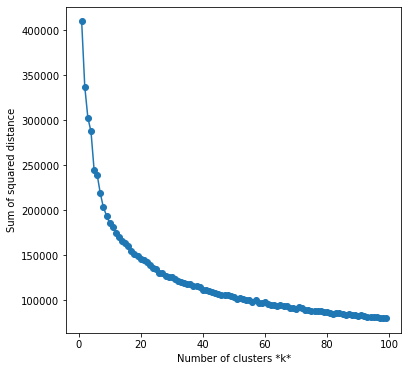

In [28]:
# # Let's explore the clustering of word embadding vector using K-Means
# # first let's find optimal number of cluster using elbow methods

# # # stardize the data in case the data are not normalized
# # df_clustering = df.copy()
# # X = StandardScaler().fit_transform(df_clustering.iloc[:, 1:])

# # workingin title word embedding
# sse=[] # sum of square error
# list_k = list(range(1, 100))

# X = scale_norm_view_vec
# for k in list_k:
#     km = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
#     km.fit(X)
#     sse.append(km.inertia_)

# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse, '-o')
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

Let's explore silhouette plot to examine different number of cluster.

In [29]:
# # use silhouette plot based on sklearn documentation page https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# #set the dataset to be working with
# X = scale_norm_view_vec

# for i, k in enumerate([2, 3, 4, 5, 6]):
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)
    
#     # Run the Kmeans algorithm
#     kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
#     labels = kmeans.fit_predict(X)
#     # centroids = kmeans.cluster_centers_

#     # Get silhouette samples
#     silhouette_vals = silhouette_samples(X, labels)

#     # Silhouette plot
#     y_ticks = []
#     y_lower, y_upper = 0, 0
#     for i, cluster in enumerate(np.unique(labels)):
#         cluster_silhouette_vals = silhouette_vals[labels == cluster]
#         cluster_silhouette_vals.sort()
#         y_upper += len(cluster_silhouette_vals)
#         ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
#         ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
#         y_lower += len(cluster_silhouette_vals)

#     # Get the average silhouette score and plot it
#     avg_score = np.mean(silhouette_vals)
#     ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
#     ax1.set_yticks([])
#     ax1.set_xlim([-0.1, 1])
#     ax1.set_xlabel('Silhouette coefficient values')
#     ax1.set_ylabel('Cluster labels')
#     ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
#     # Use PCA to flatten the data
#     embedding = PCA(n_components=2)
#     pca = pd.DataFrame(embedding.fit_transform(X), columns = ['component1','component2'])
#     pca['labels'] = kmeans.predict(X)

#     # Scatter plot of data colored with labels
#     ax2.scatter(pca['component1'], pca['component2'], c=labels)
#     # ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
#     # ax2.set_xlim([-2, 2])
#     # ax2.set_xlim([-2, 2])
#     ax2.set_xlabel('Component 1')
#     ax2.set_ylabel('Component 2')
#     ax2.set_title('Visualization of clustered data', y=1.02)
#     ax2.set_aspect('equal')
#     plt.tight_layout()
#     plt.suptitle(f'Silhouette analysis using k = {k}',
#                  fontsize=16, fontweight='semibold', y=1.05);

In [52]:
# sample data to plot with t-SNE
norm_df = pd.DataFrame(scale_norm_view_vec)
norm_df['title'] = vec_df.title
cluster_X = norm_df.iloc[:,:-2]
kmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
labels = kmeans.fit_predict(cluster_X)
norm_df['label'] = labels
target_df = norm_df.sample(800)
X = target_df.iloc[:,:-3]
labels = target_df.iloc[:,-1]
# target_df.title.iloc[40]

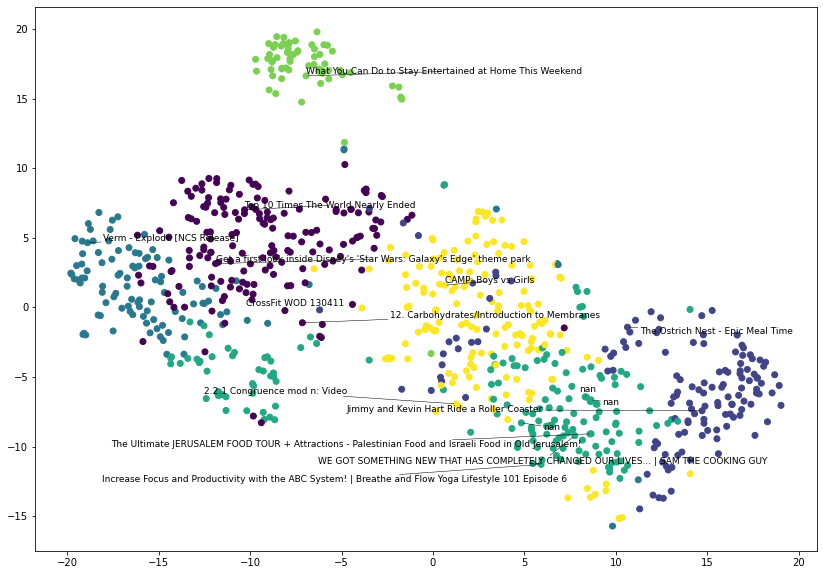

In [53]:
# pca is showing promising cluster let's try t-SNE with text adjusting
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 0, perplexity = 75)

# flatten the data and clustering then plot the cluster with t-SNE
tsne_df = pd.DataFrame(tsne.fit_transform(X), columns = ['component1','component2'])
# tsne_df['labels'] = labels
# print(tsne_df)
fig, ax = plt.subplots(figsize = (14, 10))
# sns.scatterplot(tsne_df['component1'], tsne_df['component2'], alpha = 0.5, hue=labels)
ax.scatter(tsne_df['component1'], tsne_df['component2'], c=labels)

# use adjustText to help position the text
from adjustText import adjust_text

texts = []
titles_to_plot = list(np.arange(0, 800, 50)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df.iloc[title, 0], tsne_df.iloc[title, 1], target_df.title.iloc[title], fontsize = 9))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()


### Supervised Machine Learning

In [32]:
norm_view_vec.sample(3)

,description,tags,categoryId,log_duration_secs,topicCategories,publishedDayDelta,titleVec,normalizedView
62,-0.319032,0.193920,10.0,8.045909,-1.883525,2522,0.289505,-0.709451
30371,-1.262151,-0.409837,10.0,5.459586,3.309624,2354,-0.238726,0.394218
39654,-1.014900,-0.831989,27.0,6.679599,0.976904,761,-0.636336,0.145603


In [33]:
# try using the features to predict the normalizedView using XGboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [85]:
# data do not need to be scaled for XGboost since it is based on ensemble machine learning
X, y = norm_view_vec.iloc[:, :-1], norm_view_vec.iloc[:, -1]
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                test_size = 0.3, random_state = 0)
  
# Models Instantiation
lr = LinearRegression(fit_intercept=False)
llr = Lasso(alpha=0.1)
rr = Ridge(alpha=1.0)
dr = DummyRegressor(strategy="mean")
# svr = SVR(kernel = 'linear')
# dtr = DecisionTreeRegressor(max_depth=10)
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', booster='gbtree', max_depth=8,
                  n_estimators = 50, random_state=0, learning_rate=0.05)
# Fitting the model
lr.fit(train_X, train_y)
llr.fit(train_X, train_y)
rr.fit(train_X, train_y)
dr.fit(train_X, train_y)
# svr.fit(train_X, train_y)
# dtr.fit(train_X, train_y)
xgb_r.fit(train_X, train_y)
  
# Predict the model
lr_pred = lr.predict(test_X)
llr_pred = llr.predict(test_X)
rr_pred = rr.predict(test_X)
dr_pred = dr.predict(test_X)
# svr_pred = svr.predict(test_X)
# dtr_pred = dtr.predict(test_X)
xgb_pred = xgb_r.predict(test_X)



In [86]:
def ret_metrics(test_y, pred):
  mae = metrics.mean_absolute_error(test_y, pred)
  mse = metrics.mean_squared_error(test_y, pred)
  rmse = np.sqrt(mse)

  return mae, mse, rmse

In [87]:
# prediction scores
print(f"LR metrics for mae, mse, rmse are: {ret_metrics(test_y, lr_pred)}")
print(f"LLR metrics for mae, mse, rmse are: {ret_metrics(test_y, llr_pred)}")
print(f"DR metrics for mae, mse, rmse are: {ret_metrics(test_y, dr_pred)}")
print(f"RR metrics for mae, mse, rmse are: {ret_metrics(test_y, rr_pred)}")
# print(f"SVR metrics for mae, mse, rmse are: {ret_metrics(test_y, svr_pred)}")
# print(f"DTR metrics for mae, mse, rmse are: {ret_metrics(test_y, dtr_pred)}")
print(f"XGB metrics for mae, mse, rmse are: {ret_metrics(test_y, xgb_pred)}")

LR metrics for mae, mse, rmse are: (0.4878276995656438, 1.051225937114673, 1.0252930981503157)
LLR metrics for mae, mse, rmse are: (0.48564423146049185, 1.0570711492413087, 1.0281396545417887)
DR metrics for mae, mse, rmse are: (0.4907633550523575, 1.0703031403707473, 1.0345545613309852)
RR metrics for mae, mse, rmse are: (0.4826703390766892, 1.0477307495227972, 1.0235871968341521)
XGB metrics for mae, mse, rmse are: (0.4508981540272736, 0.9122577877643299, 0.9551218706344913)


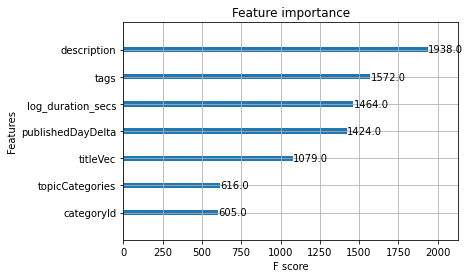

In [88]:
# plot features importance based on xgboost ensemble model
from xgboost import plot_importance

plot_importance(xgb_r)
plt.show()

In [89]:
# try neural network model for prediction
from tensorflow import keras



In [ ]:
# try adding cosine similarity as a feature